# MEGA UE5: Machine Learning
In this exercise, you will use Python to explore and get insights into a large cohort of COVID patient
cases using traditional machine learning approaches for stratification (i.e., dimensionality
reduction and clustering). You will work with EHR data (`data_ehr.csv`) that you can find in the UE5-
data.zip file. There is also a data_description.csv that includes a description of the variables
included in this EHR data set.

For the submission, you need to provide two deliverables:

1. A `.pdf` with the answers to the questions (a-f) below.

2. Your `.py` script(s).

## Part 1: Data Preprocessing
Read the EHR data (data_ehr.csv), for instance with the Pandas library. The dataset contains
missing values that are encoded with NA or empty values. Clean the dataset by removing columns
where more than 30% of the values are NA.

**(a)** *How many dimensions (attributes) and instances (cases or number of patients) does
the clean dataset contain? How many dimensions and instances did it contain before the cleaning?*

**(b)** *What type of data does the clean dataset contain?*

In [1]:
import part1 as preprocessing

data = preprocessing.read_csv('UE5-data/data_ehr.csv')
rows, columns = data.shape
print('Rows:', rows, 'Columns:', columns)

clean_data = preprocessing.clean_data(data)
clean_rows, clean_columns = clean_data.shape
print('Rows_cleaned:', clean_rows, 'Columns_cleaned:', clean_columns)

Rows: 1384 Columns: 130
Rows_cleaned: 1384 Columns_cleaned: 118


The file data_ehr.csv contains 130 dimensions (columns) and 1384 instances (rows). After preprocessing and removing columns/dimensions where more than 30% of the values are NA it only contains 118 dimensions (columns). The number of instances stays the same since removal only concerned columns.

In [5]:
print(clean_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384 entries, 0 to 1383
Columns: 118 entries, to_patient_id to therapeutic.heparin.Boolean
dtypes: bool(3), float64(32), int64(1), object(82)
memory usage: 1.2+ MB
None


In the preprocessed "cleaned" data there are 118 columns left. Each of these has a specific data type: 3 columns-bool, 32 columns-float64, 1 columns-int64, 82 columns-object

## Part 2: Clustering
Read the documentation of the scikit-learn library for clustering (https://scikit-
learn.org/1.5/modules/clustering.html).

Try a couple of different clustering algorithms to cluster the cohort of patients, based on
numerical features only. Then, decide which algorithm and with what parameters is best to use
in this case.

**(c)** *Explain your choices of clustering methods and all parameters used. Why did you
use this clustering method and parameters? What are its
advantages/disadvantages over other potential methods?*


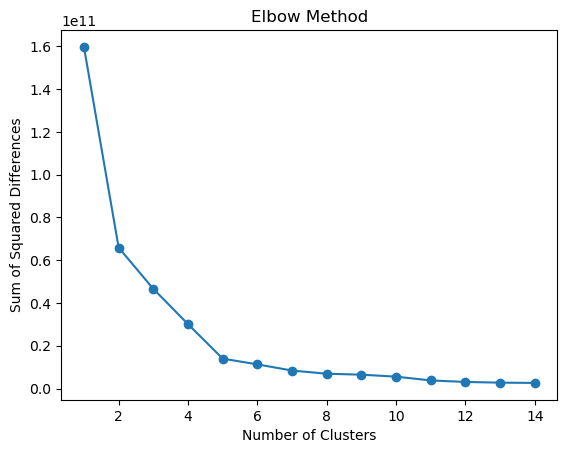

Silhouette Score: 0.9135220925159057


In [2]:
from sklearn.metrics import silhouette_score
import part2 as clustering
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, mean_shift

numeric_data = clustering.get_numerical_features(clean_data)

plt.plot(range(1, 15), clustering.elbow_method(numeric_data), marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Differences')
plt.show()

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(numeric_data)
silhouette = silhouette_score(numeric_data, clusters)
print(f"Silhouette Score: {silhouette}")

#### KMeans

KMeans is widely used clustering algorithms, which aims to partition a dataset into a predefined number of clusters (K). The algorithm minimizes the variance within each cluster. This algorithm was chosen because it is a simple yet very efficient clustering tool, which can handle large datasets. It is specialized on numerical values as well as you can compute the sum of squared distances the best. The disadvantages of KMeans would be the estimation of the number of clusters, which can be solved with the Elbow-Method. Another downside is the assumption of spherical clusters so it doesn't work great for irregular shaped clusters. Also, the algorithm is very sensitive to outliers, which can skew the mean of a cluster.  

Here first the table was reduced dimensions with numerical values only and all NAN values where replaced with the mean of the column to not distort the data. After that the first method was that was chosen was the KMeans method. For this an estimate of clusters has to be given. So the elbow method was applied. That means K-means was performed, clustering with values from 1-15. For each of the values, we calculate the average distances to the centroid (=center of cluster) across all data points. We want the point where the average distance from the centroid falls suddenly ("elbow"). It was identified to be 5 so it was put in the KMeans function - elbow point can be ambiguous Silhoutte Score highest for k=2. The initialization 'k-means++' was chosen due to the advantage of distant centroids rather than completely random initialization. The random state was chosen randomly but provides consistent results even though random initialization.

In [3]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=400, min_samples=5)
clusters = dbscan.fit_predict(numeric_data)

if len(set(clusters)) > 1: 
    silhouette_avg = silhouette_score(numeric_data, clusters)
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print("Only one cluster or noise, silhouette score cannot be computed.")


Silhouette Score: 0.4124997541647685


#### DBSCAN
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that identifies dense regions in the data and separates out sparse regions (noise). It is particularly effective in scenarios where the data contains clusters of arbitrary shapes and where there is noise. It also has a way of handling outliers - labeling with -1. These points make DBSCAN an interesting choice to compare to KMeans. Unlike methods like K-means, DBSCAN does not require the number of clusters to be specified upfront. The parameters are: eps = maximum distance between two samples for them to be considered as in the same neighborhood and min_samples = minimum number of points required to form a dense region. A disadvantage of the algorithm is the sensitivity to these parameters, meaning if they are not chosen correctly, clustering might fail. Also, DBSCAN struggles with varying density because it assumes that all clusters have a similar density. 

Here we used the same data that only contains numerical features and no NAN values again for a DBSCAN Clustering. The if-else should check if there were meaningful clusters formed and if so calculate the Silhouette Score for the clustering. Starting out with eps=0.5 (points within distance of 0.5 considered neighbors) and min_samples=5 (dense region must have >= 5 points) all data points were considered 'Noise' (labeled -1). This indicated that the eps was too low for the data, which is too sparse for these parameters. So after upping eps to 10 the Silhouette Score could be calculated. The results were negative indicating a very bad score. The highest result that could be achieved were with the parameters eps=400, min_samples=5. 

In [4]:
from sklearn.cluster import BisectingKMeans

bisecting_kmeans = BisectingKMeans(n_clusters=5, random_state=42)
clusters = bisecting_kmeans.fit_predict(numeric_data)
silhouette = silhouette_score(numeric_data, clusters)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.47031937353775144


#### Bisecting KMeans

Bisecting KMeans is a hierarchical approach of the KMeans algorithm. Its goal is the same but the direction of methodology is the other way around. It doesn't create all centroids at once randomly, but rather picks them progressively based on a previous clustering. The algorithm starts with one cluster and splits until the predefined number of clusters is reached. There are 2 strategies for selecting the cluster to split, the default being "biggest_inertia" will always split cluster with the biggest amount of points assigned to it from all clusters previously calculated. The second strategy is "largest_cluster" which selects the clusters to split based on having the most points. Both strategies were tried out, and splitting based on biggest inertia resulted in a slightly higher Silhouette Score. It adds the advantage of providing hierarchical structures useful for understanding relationships between clusters, while also reducing sensitivity to initialization by focusing on splitting problematic clusters.

The parameters were chosen to directly compare the hierarchical approach to the regular KMeans algorithm. Although when run with no parameter given for number of clusters a 0.05 higher Silhouette Score was calculated.

#### Conclusion

The decision of which clustering algorithm to choose for this data, relies on the Silhouette Score. It measures how close each point in one cluster is to the points in the neighboring clusters. A score close to +1 indicates that the points are well clustered, a score of 0 means the points are on the border of two clusters, and a negative score indicates that points might have been incorrectly clustered. Looking at the Silhouette Score of KMeans 0.9135220925159057 compared to the Silhouette Score of DBSCAN 0.4124997541647688 or Bisecting Means 0.4703193735377516 the choice seems obvious: KMeans is the best choice for clustering this data. 

## Part 3: Dimensionality Reduction and Clustering
Read the documentation of the scikit-learn library for 
[PCA](https://scikitlearn.org/dev/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)
and
[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).


**(d)** *What are the advantages/disadvantages of these two-dimensionality reduction approaches? Compare the two approaches against each other, 
theoretically.*

PCA and t-SNE are both dimensionality reduction techniques but with distinct focuses and trade-offs. PCA is a linear method that preserves global structure by identifying directions of maximum variance, making it computationally efficient, easy to interpret, and suitable for linear relationships. It does not require hyperparameter tuning but may struggle with non-linear patterns and is sensitive to feature scaling.

t-SNE, on the other hand, is a non-linear method that excels at preserving local structure, revealing clusters and relationships in high-dimensional data. It is particularly effective for visualizing complex, non-linear data in 2D or 3D. However, t-SNE is computationally expensive, requires careful hyperparameter tuning (e.g., perplexity and learning rate), and is non-parametric, meaning it cannot embed new data points easily.

In summary, PCA is best for understanding global variance and linear structures, while t-SNE is more effective for visualizing local clusters in complex datasets.

Perform these two-dimensionality reductions on your dataset and visualize the results as a
scatterplot. Subsequently, perform a clustering on top of your dimensionality reduction, according
to your observations in Part 2 of this exercise. Show your results again in a scatterplot.

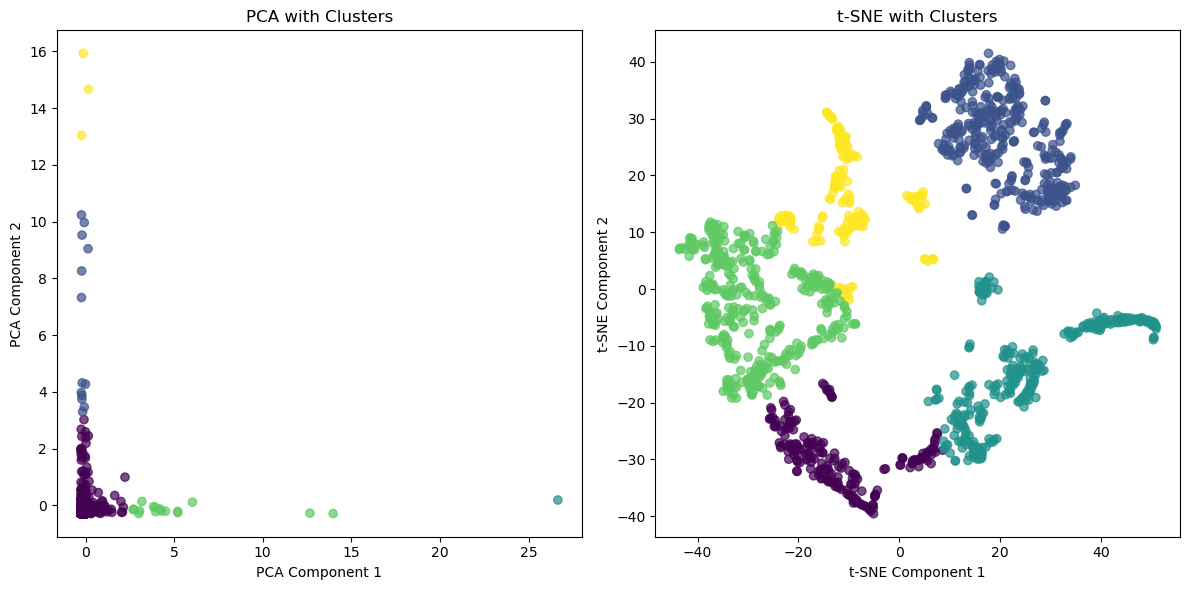

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Step 1: PCA Dimensionality Reduction
pca_model = PCA(n_components=2, whiten=True)
pca_data = pca_model.fit_transform(numeric_data)

# Step 2: t-SNE Dimensionality Reduction
tsne_model = TSNE(n_components=2, random_state=42)
tsne_data = tsne_model.fit_transform(numeric_data)

# Step 3: Perform KMeans Clustering on PCA and t-SNE Data
kmeans = KMeans(n_clusters=5, random_state=42)  # 5 clusters based on elbow method (see above)
pca_clusters = kmeans.fit_predict(pca_data)
tsne_clusters = kmeans.fit_predict(tsne_data)

# Step 4: Visualization
# PCA Scatterplot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=pca_clusters, cmap='viridis', alpha=0.7)
plt.title('PCA with Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# t-SNE Scatterplot
plt.subplot(1, 2, 2)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=tsne_clusters, cmap='viridis', alpha=0.7)
plt.title('t-SNE with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

**(e)** *What are the advantages of using clustering on top of a dimensionality reduction?*

Using clustering on top of dimensionality reduction combines the strengths of both techniques: dimensionality reduction simplifies high-dimensional data, preserving meaningful patterns while removing noise and redundancy, and clustering identifies groups or patterns within this simplified representation. This approach enhances interpretability by making clusters more distinct and visually apparent, facilitates the discovery of underlying structures in the data, and improves clustering performance by reducing computational complexity and noise sensitivity in high-dimensional spaces.


On top of your clustered dimensionality reduced outcome from the previous step, encode in the
scatterplot the '2345-7_Glucose \[Mass/volume\] in Serum or Plasma' variable. For this, you will
need to use appropriate visual channels (e.g., opacity, shape, etc.) for the datapoints.

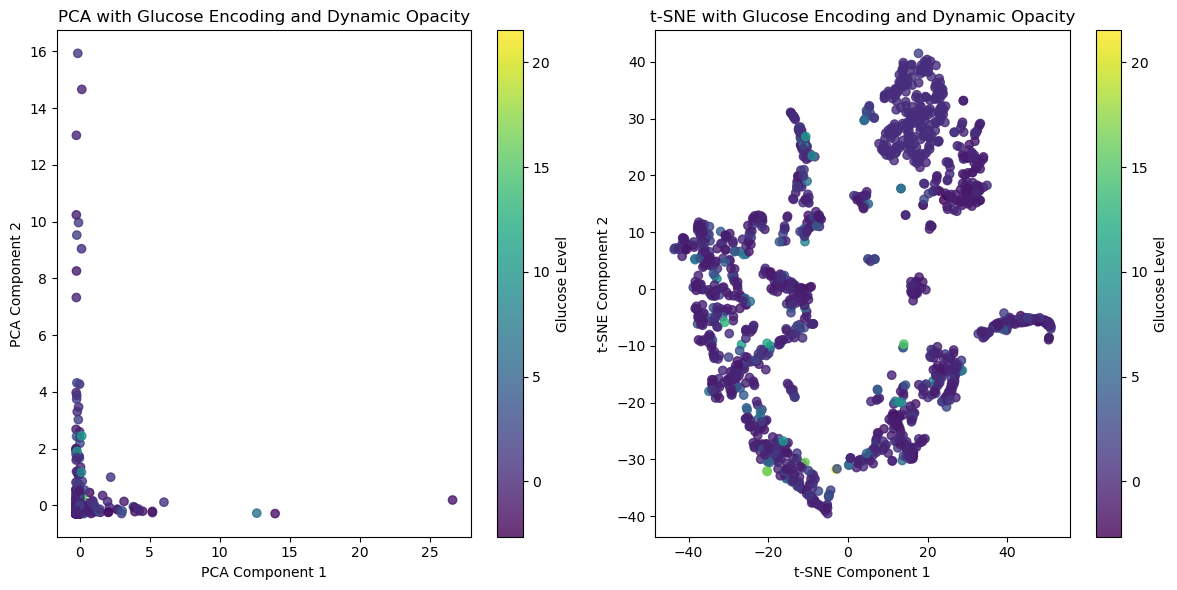

In [13]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

glucose = numeric_data['2345-7_Glucose [Mass/volume] in Serum or Plasma']

# Normalize glucose levels for better visualization
scaler = RobustScaler()
glucose_scaled = scaler.fit_transform(glucose.values.reshape(-1, 1)).flatten()


# PCA Scatterplot with Glucose Encoding and Opacity
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(
    pca_data[:, 0], pca_data[:, 1], 
    c=glucose_scaled, cmap='viridis', 
    alpha=0.8
)
plt.colorbar(label='Glucose Level')
plt.title('PCA with Glucose Encoding and Dynamic Opacity')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# t-SNE Scatterplot with Glucose Encoding and Opacity
plt.subplot(1, 2, 2)
plt.scatter(
    tsne_data[:, 0], tsne_data[:, 1], 
    c=glucose_scaled, cmap='viridis', 
    alpha=0.8
)
plt.colorbar(label='Glucose Level')
plt.title('t-SNE with Glucose Encoding and Dynamic Opacity')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

**(f)** *Explain the visual variable choices you made in visualizing the glucose variable. Do
you have any interesting observations regarding the patterns in the data?*